# Frequency analysis using RMM
FFT, autocorrelation, power spectrum, power × frequency

In [1]:
import numpy as np
from scipy import signal, ndimage
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# RMM index
f = 'data/rmm.csv'
df = pd.read_csv(f, index_col=0, parse_dates=True).dropna()

## FFT

Time series data: $x(t)$  
Fourier Transformed data: $X(\omega) = \int x(t) e^{-j\omega t} dt$

In [3]:
# Focus on RMM1 (assume continous data for simiplicity)
t = np.arange(df.shape[0])
x = df['RMM1'].values

# FFT
sampling_space = 1
x_fft = np.fft.rfft(x)
freq = np.fft.rfftfreq(len(x), d=sampling_space) 

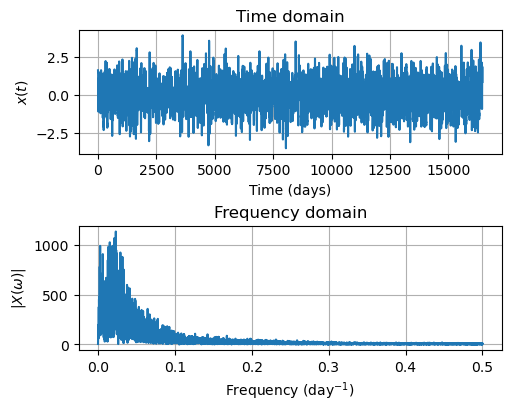

In [4]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 4), layout='constrained')

ax = axs[0]
ax.plot(t, x)
ax.set(
    title='Time domain',
    xlabel='Time (days)',
    ylabel=r'$x(t)$',
)
ax.grid()

ax = axs[1]
ax.plot(freq, np.abs(x_fft))
ax.set(
    title='Frequency domain',
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel=r'$|X(\omega)|$',
)
ax.grid()

# Autocorrelation

$$\rho (\tau) = \int x(t) x(t+\tau) dt$$

In [5]:
# acf = np.correlate(x, x, mode='full')   # slow
acf = signal.correlate(x, x, mode='full')

nlag = len(acf) // 2
lag = np.arange(-nlag, nlag+1)

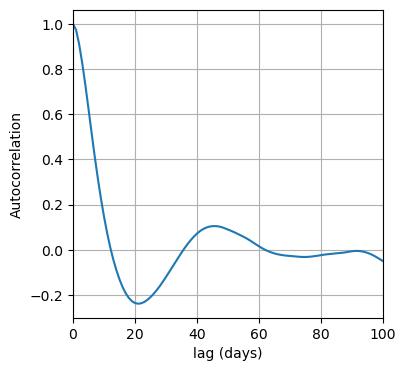

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(lag, acf / x.var() / x.size)
ax.set(
    xlim=(0, 100),
    ylabel='Autocorrelation',
    xlabel='lag (days)',
)
ax.grid()


# Power spectrum

1. Square of FFT magnitude  
$$ S(\omega) = |X(\omega)|^2 $$

2. Fourier Transform of the autocorrelation
$$ S(\omega) = \int \rho(\tau) e^{-j\omega \tau} d\tau $$

In [7]:
power_spectrum = np.abs(x_fft) ** 2

# FFT of ACF
power_spectrum_acf = np.fft.rfft(acf)
freq_acf = np.fft.rfftfreq(len(acf))

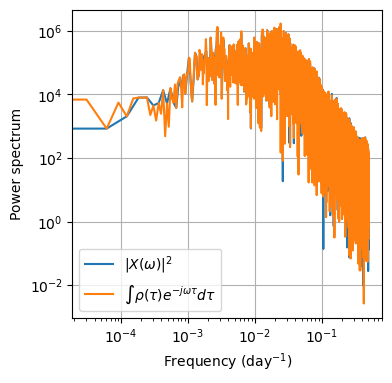

In [8]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.loglog(freq, power_spectrum, label=r'${|X(\omega)|^2}$')
ax.loglog(
    freq_acf, np.abs(power_spectrum_acf), 
    label=r'$\int \rho(\tau) e^{-j\omega \tau} d\tau$'
)
ax.legend()
ax.set(
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel='Power spectrum',
)
ax.grid()

### log(frequency) vs power × frequency plot
The area under any portion of the curve is equal to the variance within that frequency band.

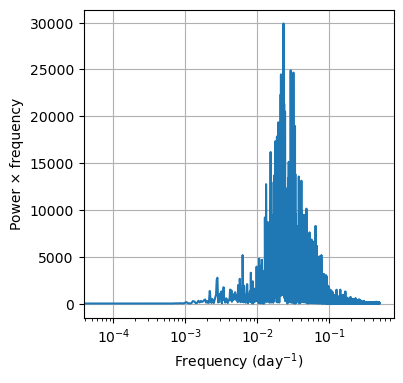

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.semilogx(freq, power_spectrum*freq)
ax.set(
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel='Power × frequency',
)
ax.grid()

It is common to smooth the power density for better visualization.

This plot is similar to Fig. 2 of [Wheeler and Hendon (2004)](https://doi.org/10.1175/1520-0493%282004%29132<1917:AARMMI>2.0.CO;2).

In [10]:
# Gaussian filter
sigma = 10  # Standard deviation for Gaussian kernel
power_spectrum_smth = ndimage.gaussian_filter(power_spectrum, sigma)

In [11]:
total_variance = np.trapezoid(power_spectrum*freq, x=freq)

# Explained variance in 30- to 80-day band
idx = (freq > 1/80) & (freq < 1/30)
band_variance = np.trapezoid(power_spectrum[idx]*freq[idx], x=freq[idx])
band_variance / total_variance

np.float64(0.4478268021496182)

/tmp/ipykernel_259513/1641721415.py:19: RuntimeWarning: divide by zero encountered in divide
  sax = ax.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))


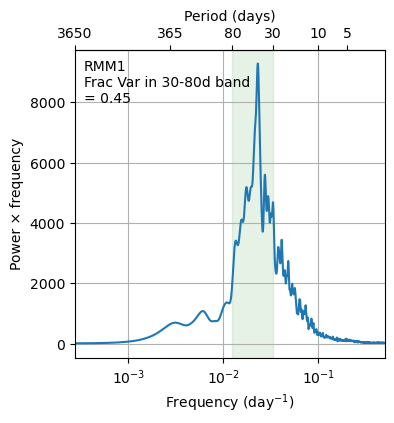

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.semilogx(freq, power_spectrum_smth*freq)
ax.set(
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel='Power × frequency',
    xlim=(1/3650, freq[-1]),
)
ax.grid()
ax.minorticks_off()
ax.text(
    0.03, 0.97, 
    f'RMM1\nFrac Var in 30-80d band\n= {band_variance / total_variance:.2f}', 
    ha='left', va='top', transform=ax.transAxes
)

# Secondary axis
xticks = [5, 10, 30, 80, 365, 3650]
sax = ax.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))
sax.set(
    xlabel='Period (days)',
    xticks=xticks,
    xticklabels=xticks,
)
sax.minorticks_off()

ax.axvspan(1/80, 1/30, color='g', alpha=0.1)